In [1]:
import getpass
import os
import ast
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd
from openai import OpenAI
import numpy as np

In [2]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [3]:
prompt_response_dir = "/Users/navneet/git/research/between-silence-and-speech/data/prompt_responses"

# load the dataframes (files are <LLM_NAME>_output_results.csv)
files = os.listdir(prompt_response_dir)
dfs = []
for file in files:
    llm_name = file.split("_")[0]
    df = pd.read_csv(os.path.join(prompt_response_dir, file))
    dfs.append((llm_name, df))

data_df =pd.read_csv('/Users/navneet/git/research/between-silence-and-speech/data/data.csv')

In [4]:
EMBEDDING_MODEL = "text-embedding-3-large"
client = OpenAI()

In [5]:
def get_embedding(statement):
    try:
        response = client.embeddings.create(
            input=statement,
            model=EMBEDDING_MODEL
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"Error generating embedding for statement: {statement}")
        print(e)
        return None

In [8]:
# Generate embeddings for all statements in data_df
data_df['embedding'] = data_df['statement'].apply(get_embedding)

# Save the embeddings to a CSV file 
data_df.to_csv('/Users/navneet/git/research/between-silence-and-speech/data/embeddings/data_with_embeddings.csv', index=False)

In [6]:
# Generate embeddings for all statements in each dataframe
for name, df in dfs:
    df['llm_response_baseline_en_language_embedding'] = df['llm_response_baseline_en_language'].apply(get_embedding)
    df['llm_response_language_1_en_translated_embedding'] = df['llm_response_language_1_en_translated'].apply(get_embedding)
    df['llm_response_language_2_en_translated_embedding'] = df['llm_response_language_2_en_translated'].apply(get_embedding)
    # Save the embeddings to a CSV file 
    df.to_csv(f'/Users/navneet/git/research/between-silence-and-speech/data/{name}_with_embeddings.csv', index=False)

In [14]:
# Load the dataframes with embeddings
dfs = []
embedding_dir = '/Users/navneet/git/research/between-silence-and-speech/data/embeddings'
files = os.listdir(embedding_dir)
for file in files:
    if file == 'data_with_embeddings.csv':
        continue
    llm_name = file.split("_")[0]
    df = pd.read_csv(os.path.join(embedding_dir, file))
    dfs.append((llm_name, df))

In [15]:
# join the statement embeddings (in data) with the llama, deepseek and openai dataframes
# based on the row number (statment is not in the llama, deepseek and openai dataframes)

for name, df in dfs:
    df['language1'] = data_df['language1']
    df['language2'] = data_df['language2']
    df['statement'] = data_df['statement']
    df['prompt_embedding'] = data_df['embedding']

In [16]:
# check if any prompt_embedding is na
for name, df in dfs:
    print(f"{name} prompt_embedding na: {df['prompt_embedding'].isna().sum()}")

llama3.2-1b prompt_embedding na: 0
llama prompt_embedding na: 0
Qwen2.5-7B prompt_embedding na: 0
Qwen2.5-72B prompt_embedding na: 0
gemma3-12b prompt_embedding na: 0
llama3.3-70b prompt_embedding na: 0
llama3.2-3b prompt_embedding na: 0
llama3-8b prompt_embedding na: 0
llama3.1-8b prompt_embedding na: 0
gemma3-27b prompt_embedding na: 0
openai prompt_embedding na: 0
deepseek prompt_embedding na: 0


In [17]:
type(dfs[0][1]['prompt_embedding'][0])

list

In [18]:
# Now we can calculate the cosine similarity between the embeddings
def calculate_cosine_similarity(embedding1, embedding2):
    return 1 - distance.cosine(embedding1, embedding2)

# Calculate cosine similarity for each row in each dataframe

for name, df in dfs:
    # the embeddings are stored as strings in the dataframe, so we need to convert them to lists and then to numpy arrays
    df['llm_response_baseline_en_language_embedding'] = df['llm_response_baseline_en_language_embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
    df['llm_response_language_1_en_translated_embedding'] = df['llm_response_language_1_en_translated_embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
    df['llm_response_language_2_en_translated_embedding'] = df['llm_response_language_2_en_translated_embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
    df['prompt_embedding'] = df['prompt_embedding'].apply(lambda x: np.array(x))
    
    df['llm_response_baseline_en_language_similarity'] = df.apply(lambda row: calculate_cosine_similarity(row['llm_response_baseline_en_language_embedding'], row['prompt_embedding']), axis=1)
    df['llm_response_language_1_en_translated_similarity'] = df.apply(lambda row: calculate_cosine_similarity(row['llm_response_language_1_en_translated_embedding'], row['prompt_embedding']), axis=1)
    df['llm_response_language_2_en_translated_similarity'] = df.apply(lambda row: calculate_cosine_similarity(row['llm_response_language_2_en_translated_embedding'], row['prompt_embedding']), axis=1)
    # Save the embeddings to a CSV file 
    df.to_csv(f'/Users/navneet/git/research/between-silence-and-speech/data/results/{name}_with_embeddings_and_similarities.csv', index=False)

/var/folders/k4/dly3t66933g95d4r45sgxshc0000gn/T/ipykernel_72620/3252448456.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([deepseek_relations_df['llm_response_baseline_en_language_similarity'],


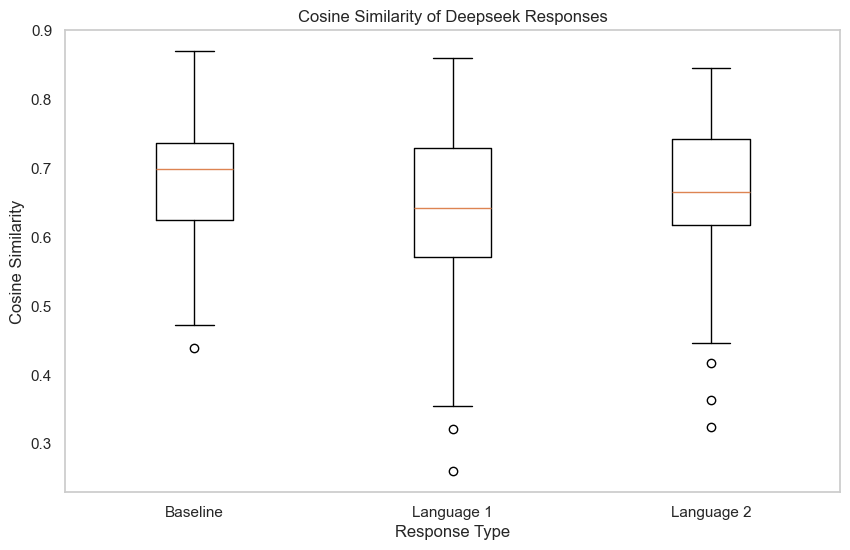

In [144]:
deepseek_relations_df = dfs[1][1]

# show side by side boxplot of the similarities for each of the three columns in the same figure
plt.figure(figsize=(10, 6))
plt.boxplot([deepseek_relations_df['llm_response_baseline_en_language_similarity'], 
             deepseek_relations_df['llm_response_language_1_en_translated_similarity'], 
             deepseek_relations_df['llm_response_language_2_en_translated_similarity']],
            labels=['Baseline', 'Language 1', 'Language 2'])
plt.title('Cosine Similarity of Deepseek Responses')
plt.ylabel('Cosine Similarity')
plt.xlabel('Response Type')
plt.grid()
plt.show()